# Main characteristics 
- non dimensionalization of datasets + hot encoding of labels (classes)
- 2 conv (32,64 filters, 3x3), relu, BN, dropout 25%
- 2 dense hidden layers (256, 128 neurones) , relu, BN, dropout 25%
- softmax
- loss="Categorical_crossentropy", optimizer="adam"

ACCURACY 

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout, LeakyReLU, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [3]:
# Load CIFAR-10 dataset & check data dimension
# Ref: Homepage: https://www.cs.toronto.edu/~kriz/cifar.html

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data() 

print("X_train:",X_train.shape)
print("y_train:",y_train.shape)
print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)

X_train: (50000, 32, 32, 3)
y_train: (50000, 1)
X_test:  (10000, 32, 32, 3)
y_test:  (10000, 1)


In [4]:
# non-dimensionalisation of training and test datasets, define classes
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
N_classes = len(class_names)

X_train = X_train /255.0
X_test = X_test / 255.0

y_train_cat = to_categorical (y_train)
y_test_cat = to_categorical (y_test)

print("X_train:",X_train.shape)
# print("y_train:",y_train.shape)
print("y_train_cat:",y_train_cat.shape)
print("X_test: ",X_test.shape)
# print("y_test: ",y_test.shape)
print("y_test_cat: ",y_test_cat.shape)

X_train: (50000, 32, 32, 3)
y_train_cat: (50000, 10)
X_test:  (10000, 32, 32, 3)
y_test_cat:  (10000, 10)


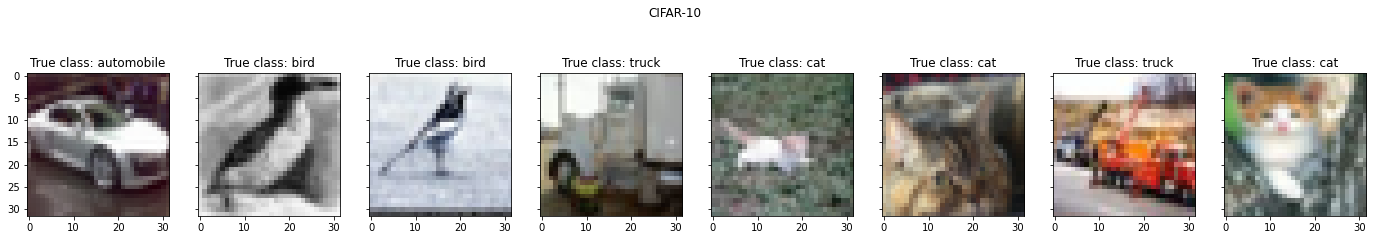

In [5]:
# Define classes and print a couple of pictures for fun
Npics=8
fig, ax = plt.subplots(nrows=1, ncols=Npics, figsize=(Npics*3,4), sharey=True)
fig.suptitle('CIFAR-10')
for i in range(Npics):
  rnd = np.random.randint(1000)
  ax[i].imshow(X_train[rnd,:,:,:])
  ax[i].set_title (str("True class: "+class_names[y_train[rnd][0]]))


In [6]:
# seed = 100

model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(N_classes, activation='softmax'))

# model.summary()

In [7]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.003, 
    decay_steps = 100000, 
    decay_rate = 0.96, 
    staircase=True
)

myoptimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
myLoss = "categorical_crossentropy" 
mymetrics = ["accuracy"] #, Precision(name='precision'), Recall(name='recall')]

model.compile(
    loss = myLoss,
    optimizer = myoptimizer,
    metrics = mymetrics,
)

In [8]:
history = model.fit(X_train, y_train_cat, 
                epochs=30, 
                shuffle=True, 
                validation_data=(X_test, y_test_cat),
                batch_size = 32, 
                )

Epoch 1/30
1563/1563 [==============================] - 20s 10ms/step - loss: 1.6726 - accuracy: 0.4300 - val_loss: 1.0855 - val_accuracy: 0.6149
Epoch 2/30
1563/1563 [==============================] - 15s 10ms/step - loss: 0.9985 - accuracy: 0.6486 - val_loss: 0.9734 - val_accuracy: 0.6536
Epoch 3/30
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8319 - accuracy: 0.7076 - val_loss: 0.8846 - val_accuracy: 0.6859
Epoch 4/30
1563/1563 [==============================] - 15s 10ms/step - loss: 0.7140 - accuracy: 0.7509 - val_loss: 0.8625 - val_accuracy: 0.6999
Epoch 5/30
1563/1563 [==============================] - 15s 10ms/step - loss: 0.6126 - accuracy: 0.7868 - val_loss: 0.8026 - val_accuracy: 0.7261
Epoch 6/30
1563/1563 [==============================] - 16s 10ms/step - loss: 0.5041 - accuracy: 0.8195 - val_loss: 0.8956 - val_accuracy: 0.7079
Epoch 7/30
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4304 - accuracy: 0.8498 - val_loss: 0.8332 -

313/313 [==============================] - 1s 4ms/step - loss: 1.0922 - accuracy: 0.7365


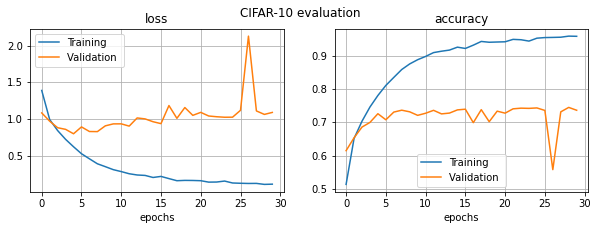

In [9]:
# note: using adam learning rate=0.0001 and batch=32

Nfigs = len(mymetrics)+1
H = pd.DataFrame(history.history)
fig, ax = plt.subplots(nrows=1, ncols=Nfigs, figsize=(Nfigs*5,3))
fig.suptitle('CIFAR-10 evaluation')

for i in range(Nfigs):
    H.iloc[:,i].plot(ax=ax[i], label='Training ') 
    H.iloc[:,i+Nfigs].plot(ax=ax[i], label='Validation ')
    ax[i].set_title(H.columns[i])
    ax[i].legend()
    ax[i].grid(True)
    ax[i].set_xlabel('epochs')

training = model.evaluate(X_train, y_train_cat)
evaluation = model.evaluate(X_test, y_test_cat)


# NOTES:
changes & impact:
- optim = RMSprop --> no major gain 
  

Suggestions for next model:
- use different batch_validation and shuffle within model
- investigate different loss models and optimizers (adam)
- add convolution layers (VGG-5 or VGG-16)